In [1]:
from symforce import sympy as sm
from symforce import geo

In [2]:
pose = geo.Pose2(
    t=geo.V2.symbolic("t"),
    R=geo.Rot2.symbolic("R")
)
landmark = geo.V2.symbolic("L")

In [3]:
landmark_body = pose.inverse() * landmark

In [4]:
landmark_body.jacobian(pose)

[-L0*R_im + L1*R_re + t0*R_im - t1*R_re, -R_re, -R_im]
[-L0*R_re - L1*R_im + t0*R_re + t1*R_im, R_im, -R_re]

In [5]:
sm.atan2(landmark_body[1], landmark_body[0])

atan2(-L0*R_im + L1*R_re - (-t0*R_im + t1*R_re), L0*R_re + L1*R_im - (t0*R_re + t1*R_im))

In [6]:
geo.V3.symbolic("x").norm(epsilon=sm.epsilon)

sqrt(epsilon + x0**2 + x1**2 + x2**2)

In [7]:
from symforce import typing as T

def bearing_residual(
    pose: geo.Pose2, landmark: geo.V2, angle: T.Scalar, epsilon: T.Scalar
) -> geo.V1:
    t_body = pose.inverse() * landmark
    predicted_angle = sm.atan2(t_body[1], t_body[0], epsilon=epsilon)
    return geo.V1(sm.wrap_angle(predicted_angle - angle))

In [8]:
def odometry_residual(
    pose_a: geo.Pose2, pose_b: geo.Pose2, dist: T.Scalar, epsilon: T.Scalar
) -> geo.V1:
    return geo.V1((pose_b.t - pose_a.t).norm(epsilon=epsilon) - dist)

In [9]:
from symforce.opt.factor import Factor

num_poses = 3
num_landmarks = 3

factors = []

# Bearing factors
for i in range(num_poses):
    for j in range(num_landmarks):
        factors.append(Factor(
            residual=bearing_residual,
            keys=[f"poses[{i}]", f"landmarks[{j}]", f"angles[{i}][{j}]", "epsilon"],
        ))

# Odometry factors
for i in range(num_poses - 1):
    factors.append(Factor(
        residual=odometry_residual,
        keys=[f"poses[{i}]", f"poses[{i + 1}]", f"distances[{i}]", "epsilon"],
    ))

In [10]:
from symforce.opt.optimizer import Optimizer

optimizer = Optimizer(
    factors=factors,
    optimized_keys=[f"poses[{i}]" for i in range(num_poses)],
    # So that we save more information about each iteration, to visualize later:
    debug_stats=True,
)

In [11]:
import numpy as np
from symforce.values import Values

initial_values = Values(
    poses=[geo.Pose2.identity()] * num_poses,
    landmarks=[geo.V2(-2, 2), geo.V2(1, -3), geo.V2(5, 2)],
    distances=[1.7, 1.4],
    angles=np.deg2rad([[145, 335, 55], [185, 310, 70], [215, 310, 70]]).tolist(),
    epsilon=sm.default_epsilon,
)

In [12]:
result = optimizer.optimize(initial_values)

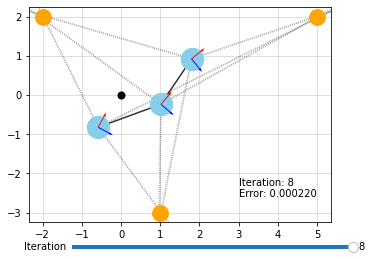

In [13]:
from symforce.examples.robot_2d_triangulation.plotting import plot_solution
plot_solution(optimizer, result)

In [14]:
from symforce.codegen import Codegen, CppConfig

codegen = Codegen.function(bearing_residual, config=CppConfig())

In [15]:
codegen_linearization = codegen.with_linearization(
    which_args=["pose"]
)

In [16]:
metadata = codegen_linearization.generate_function()
print(open(metadata.generated_files[0]).read())

// -----------------------------------------------------------------------------
// This file was autogenerated by symforce from template:
//     cpp_templates/function/FUNCTION.h.jinja
// Do NOT modify by hand.
// -----------------------------------------------------------------------------

#pragma once

#include <Eigen/Dense>

#include <sym/pose2.h>

namespace sym {

/**
 * This function was autogenerated from a symbolic function. Do not modify by hand.
 *
 * Symbolic function: bearing_residual
 *
 * Args:
 *     pose: Pose2
 *     landmark: Matrix21
 *     angle: Scalar
 *     epsilon: Scalar
 *
 * Outputs:
 *     res: Matrix11
 *     jacobian: (1x3) jacobian of res wrt arg pose (3)
 *     hessian: (3x3) Gauss-Newton hessian for arg pose (3)
 *     rhs: (3x1) Gauss-Newton rhs for arg pose (3)
 */
template <typename Scalar>
void BearingFactor(const sym::Pose2<Scalar>& pose, const Eigen::Matrix<Scalar, 2, 1>& landmark,
                   const Scalar angle, const Scalar epsilon,
    